In [1]:
import sys
import torch
import geoopt

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import trange
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from geoopt import linalg, ManifoldParameter, Stiefel
from geoopt.optim import RiemannianSGD, RiemannianAdam
from copy import deepcopy

sys.path.append("./lib/data")
from get_data import get_data, get_cov

sys.path.append("./lib/spdnet")
import nn as nn_spd
from optimizers import MixOptimizer

sys.path.append("./lib")
from swspd import sliced_wasserstein_spd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

### Data

In [3]:
subject = 1
Xs, ys = get_data(subject, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(subject, False, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1

In [4]:
print(Xs.shape, cov_Xs.shape, Xt.shape, cov_Xt.shape)

(273, 22, 1750) torch.Size([273, 1, 1, 22, 22]) (281, 22, 1750) torch.Size([281, 1, 1, 22, 22])


In [5]:
d = 22
n_classes = 4

freq = 0

In [6]:
def plot_tsne(Xs, Xt, suptitle=None):
    log_Xs = linalg.sym_logm(Xs.detach().cpu()).reshape(-1, d*d)
    log_Xt = linalg.sym_logm(Xt.detach().cpu()).reshape(-1, d*d)

    log_data = torch.cat([log_Xs, log_Xt], dim=0)

    X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(log_data.numpy())


    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
    ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

    ax[0].legend()
    ax[1].legend()
    
    if suptitle is not None:
        plt.suptitle(suptitle)
        
    plt.show()

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


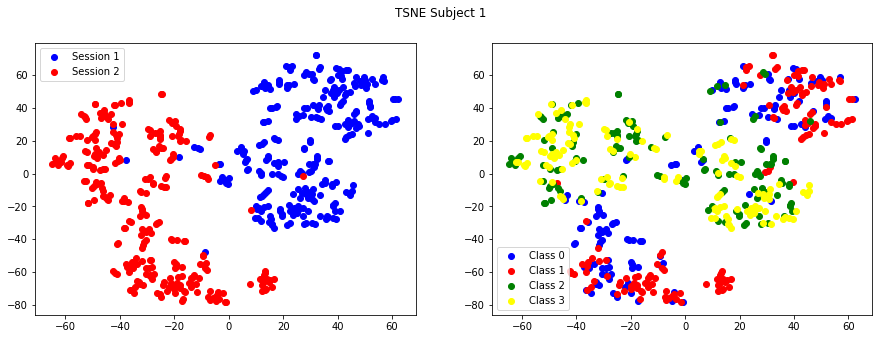

In [7]:
plot_tsne(cov_Xs[:,:,freq], cov_Xt[:,:,freq], suptitle="TSNE Subject 1")

### Learnable Transformation

In [8]:
class Translation(nn.Module):
    def __init__(self, d):
        super().__init__()
        
        manifold_spdai = geoopt.SymmetricPositiveDefinite("AIM")        
        self._W = ManifoldParameter(torch.eye(d, dtype=torch.double, device=device), manifold=manifold_spdai)
        
        with torch.no_grad():
            self._W.proj_()
        
    def forward(self, X):
        return torch.matmul(self._W, torch.matmul(X, self._W.T))

In [9]:
class Rotation(nn.Module):
    def __init__(self, d):
        super().__init__()
        
        manifold = Stiefel()        
        self._W = ManifoldParameter(torch.eye(d, dtype=torch.double, device=device), manifold=manifold)
        
        with torch.no_grad():
            self._W.proj_()
        
    def forward(self, X):
        return torch.matmul(self._W, torch.matmul(X, self._W.T))

In [10]:
class Rescaling(nn.Module):
    def __init__(self, d):
        super().__init__()
        pass

In [11]:
class Transformations(nn.Module):
    def __init__(self, d):
        super().__init__()
        
        self.translation = Translation(d)
#         self.rescaling = Rescaling(d)
        self.rotation = Rotation(d)
    
    def forward(self, X):
        Y = self.translation(X)
#         Y = self.rescaling(Y)
        Y = self.rotation(Y)
        return Y

In [12]:
epochs = 1000
num_projs = 500

model = Transformations(22).to(device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-2)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

L_loss = []

pbar = trange(epochs)

for e in pbar:
    zt = model(cov_Xt[:,:,freq])
    loss = sliced_wasserstein_spd(zt[:,0], cov_Xs[:,0,freq], num_projs, device, p=2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    L_loss.append(loss.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:22<00:00,  1.35it/s, loss = 0.002]


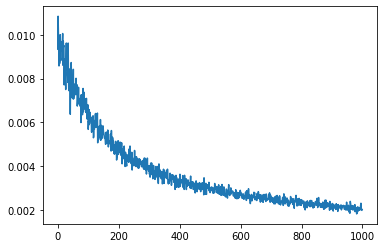

In [13]:
plt.plot(L_loss)
plt.show()

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


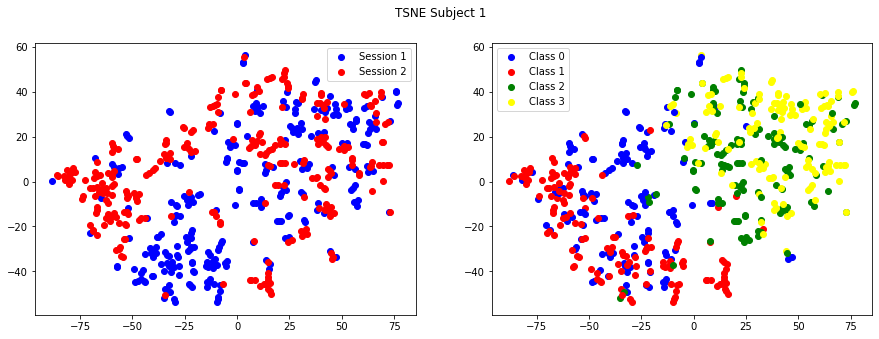

In [14]:
plot_tsne(cov_Xs[:,:,freq], model(cov_Xt[:,:,freq]), suptitle="TSNE Subject 1")

In [15]:
log_Xs = linalg.sym_logm(cov_Xs[:,0,0].detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0].detach().cpu()).reshape(-1, d*d)

for k in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(log_Xs, ys)
    print(k, neigh.score(log_Xt, yt))

1 0.5587188612099644
2 0.6263345195729537
3 0.6654804270462633
4 0.6690391459074733
5 0.6868327402135231
6 0.6619217081850534
7 0.6903914590747331
8 0.6868327402135231
9 0.6761565836298933


In [17]:
log_Xs = linalg.sym_logm(cov_Xs[:,0,0].detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(model(cov_Xt[:,:,0]).detach().cpu()).reshape(-1, d*d)

for k in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(log_Xs, ys)
    print(k, neigh.score(log_Xt, yt))

1 0.5907473309608541
2 0.6298932384341637
3 0.6654804270462633
4 0.701067615658363
5 0.697508896797153
6 0.7153024911032029
7 0.693950177935943
8 0.693950177935943
9 0.7117437722419929
